# Lab work: Eco-driving

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from scipy.signal import savgol_filter
import math
from geopy.distance import geodesic

In [127]:
def parse_data_fixed(file_path):
    # 分别读取不同类型的数据
    gps_rows = []
    acc_rows = []  
    gyro_rows = []
    rot_rows = []
    
    # 读取文件并分类
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split(',')
            if len(values) < 2:
                continue
                
            data_type = int(values[0])
            
            if data_type == 0:  # GPS
                gps_rows.append(values)
            elif data_type == 1:  # 加速度计
                acc_rows.append(values)
            elif data_type == 2:  # 陀螺仪
                gyro_rows.append(values)
            elif data_type == 3:  # 旋转向量
                rot_rows.append(values)
    
    # 创建GPS DataFrame (7列)
    gps_df = pd.DataFrame()
    if gps_rows:
        gps_df = pd.DataFrame(gps_rows)
        gps_df.columns = ['data_type', 'timestamp', 'latitude', 'longitude', 'altitude', 'speed', 'satellites']
        # 转换数据类型
        gps_df['data_type'] = gps_df['data_type'].astype(int)
        gps_df['timestamp'] = gps_df['timestamp'].astype(int)
        gps_df['latitude'] = gps_df['latitude'].astype(float)
        gps_df['longitude'] = gps_df['longitude'].astype(float)
        gps_df['altitude'] = gps_df['altitude'].astype(float)
        gps_df['speed'] = gps_df['speed'].astype(float)
        gps_df['satellites'] = gps_df['satellites'].astype(int)
    
    # 创建加速度计DataFrame (6列)
    acc_df = pd.DataFrame()
    if acc_rows:
        acc_df = pd.DataFrame(acc_rows)
        acc_df.columns = ['data_type', 'timestamp', 'timestamp_us', 'x', 'y', 'z']
        # 转换数据类型
        acc_df['data_type'] = acc_df['data_type'].astype(int)
        acc_df['timestamp'] = acc_df['timestamp'].astype(int)
        acc_df['timestamp_us'] = acc_df['timestamp_us'].astype(int)
        acc_df['x'] = acc_df['x'].astype(float)
        acc_df['y'] = acc_df['y'].astype(float)
        acc_df['z'] = acc_df['z'].astype(float)
    
    # 创建陀螺仪DataFrame (6列)
    gyro_df = pd.DataFrame()
    if gyro_rows:
        gyro_df = pd.DataFrame(gyro_rows)
        gyro_df.columns = ['data_type', 'timestamp', 'timestamp_us', 'x', 'y', 'z']
        # 转换数据类型
        gyro_df['data_type'] = gyro_df['data_type'].astype(int)
        gyro_df['timestamp'] = gyro_df['timestamp'].astype(int)
        gyro_df['timestamp_us'] = gyro_df['timestamp_us'].astype(int)
        gyro_df['x'] = gyro_df['x'].astype(float)
        gyro_df['y'] = gyro_df['y'].astype(float)
        gyro_df['z'] = gyro_df['z'].astype(float)
    
    # 创建旋转向量DataFrame (7列)
    rot_df = pd.DataFrame()
    if rot_rows:
        rot_df = pd.DataFrame(rot_rows)
        rot_df.columns = ['data_type', 'timestamp', 'timestamp_us', 'i', 'j', 'k', 'real']
        # 转换数据类型
        rot_df['data_type'] = rot_df['data_type'].astype(int)
        rot_df['timestamp'] = rot_df['timestamp'].astype(int)
        rot_df['timestamp_us'] = rot_df['timestamp_us'].astype(int)
        rot_df['i'] = rot_df['i'].astype(float)
        rot_df['j'] = rot_df['j'].astype(float)
        rot_df['k'] = rot_df['k'].astype(float)
        rot_df['real'] = rot_df['real'].astype(float)
    
    # 输出数据摘要
    print(f"Parsed data summary:")
    print(f"GPS data: {len(gps_df)} records")
    print(f"Accelerometer data: {len(acc_df)} records")
    print(f"Gyroscope data: {len(gyro_df)} records")
    print(f"Rotation vector data: {len(rot_df)} records")
    
    return {
        'gps': gps_df,
        'acc': acc_df,
        'gyro': gyro_df,
        'rot': rot_df
    }

In [128]:
def check_missing_values(data_dict):
    print("\n" + "="*50)
    print("DETAILED DATA INSPECTION")
    print("="*50)
    
    for data_type, df in data_dict.items():
        print(f"\n{'='*20} {data_type.upper()} DATA {'='*20}")
        
        if df.empty:
            print(f"No {data_type} data available.")
            continue
        
        # 检查数据行数和列数
        print(f"Shape: {df.shape} (rows, columns)")
        
        # 检查列名
        print(f"Columns: {list(df.columns)}")
        
        # 检查缺失值
        missing = df.isna().sum()
        print(f"\n{data_type.upper()} missing values:")
        for col, count in missing.items():
            print(f"  {col}: {count}")
        
        # 检查基本统计信息
        print(f"\n{data_type.upper()} basic statistics:")
        print(df.describe())
        
        # 检查重复值
        duplicates = df.duplicated().sum()
        print(f"\nDuplicate rows in {data_type} data: {duplicates}")
        
        # 检查数据范围有效性
        print(f"\nData validity checks for {data_type} data:")
        
        if data_type == 'gps':
            # 检查坐标范围
            invalid_lat = df[(df['latitude'] < -90) | (df['latitude'] > 90)].shape[0]
            invalid_lon = df[(df['longitude'] < -180) | (df['longitude'] > 180)].shape[0]
            print(f"  Invalid latitude values: {invalid_lat}")
            print(f"  Invalid longitude values: {invalid_lon}")
            
            # 检查速度范围（假设正常车辆速度不超过300 km/h）
            if 'speed' in df.columns:
                extreme_speed = df[df['speed'] > 300].shape[0]
                print(f"  Extreme speed values (>300): {extreme_speed}")
        
        elif data_type == 'acc':
            # 检查加速度范围（假设正常加速度不超过20g）
            extreme_acc = df[(df['x'].abs() > 20) | (df['y'].abs() > 20) | (df['z'].abs() > 20)].shape[0]
            print(f"  Extreme acceleration values (>20g): {extreme_acc}")
        
        elif data_type == 'gyro':
            # 检查角速度范围（假设正常角速度不超过10rad/s）
            extreme_gyro = df[(df['x'].abs() > 10) | (df['y'].abs() > 10) | (df['z'].abs() > 10)].shape[0]
            print(f"  Extreme angular velocity values (>10rad/s): {extreme_gyro}")
        
        elif data_type == 'rot':
            # 检查旋转向量范围（i,j,k通常在-1到1之间）
            extreme_rot = df[(df['i'].abs() > 1) | (df['j'].abs() > 1) | (df['k'].abs() > 1)].shape[0]
            print(f"  Potentially unusual rotation vector values: {extreme_rot}")
        
        # 检查时间戳顺序
        if 'timestamp' in df.columns:
            is_sorted = df['timestamp'].is_monotonic_increasing
            print(f"  Timestamp in chronological order: {is_sorted}")
            
            if not is_sorted:
                reversed_timestamps = (df['timestamp'].diff() < 0).sum()
                print(f"  Number of reversed timestamp pairs: {reversed_timestamps}")
    
    print("\n" + "="*50)
    print("END OF DATA INSPECTION")
    print("="*50)

In [129]:
def extract_features(data_dict):
    features = {}
    
    if not data_dict['gps'].empty:
        gps_df = data_dict['gps']
        
        distances = []
        gradients = []
        
        for i in range(1, len(gps_df)):
            point1 = (gps_df['latitude'].iloc[i-1], gps_df['longitude'].iloc[i-1])
            point2 = (gps_df['latitude'].iloc[i], gps_df['longitude'].iloc[i])
            distance = geodesic(point1, point2).meters
            distances.append(distance)
            
            if distance > 0:
                elevation_change = gps_df['altitude'].iloc[i] - gps_df['altitude'].iloc[i-1]
                gradient = elevation_change / distance
            else:
                gradient = 0
            gradients.append(gradient)
        
        gps_df.loc[1:, 'distance'] = distances
        gps_df.loc[1:, 'gradient'] = gradients
        gps_df.loc[0, 'distance'] = 0
        gps_df.loc[0, 'gradient'] = 0
        
        gps_df['speed_change'] = gps_df['speed'].diff().fillna(0)
        gps_df['acceleration'] = gps_df['speed_change'] / (gps_df['timestamp'].diff().fillna(1) / 1000)
        
        features['route'] = gps_df
    
    if not data_dict['acc'].empty:
        acc_df = data_dict['acc']
        
        acc_df['magnitude'] = np.sqrt(acc_df['x']**2 + acc_df['y']**2 + acc_df['z']**2)
        
        acc_df['jerk'] = acc_df['magnitude'].diff().fillna(0) / (acc_df['timestamp'].diff().fillna(1) / 1000)
        
        acc_df['jerk_smooth'] = savgol_filter(acc_df['jerk'], 
                                              min(21, len(acc_df) - (len(acc_df) % 2) - 1), 
                                              3)
        
        features['behavior'] = acc_df
    
    if not data_dict['gyro'].empty:
        gyro_df = data_dict['gyro']
        
        gyro_df['turning_rate'] = np.abs(gyro_df['z'])
        
        features['turning'] = gyro_df
    
    return features

In [130]:
def model_energy_consumption(features):
    
    if 'route' in features and 'behavior' in features:
        route_times = features['route']['timestamp'].values
        behavior_times = features['behavior']['timestamp'].values
        
        combined_data = []
        
        for i, row in features['route'].iterrows():
            gps_time = row['timestamp']
            closest_acc_idx = np.argmin(np.abs(behavior_times - gps_time))
            
            entry = {
                'timestamp': gps_time,
                'speed': row['speed'],
                'acceleration': row['acceleration'],
                'gradient': row['gradient'],
                'acc_x': features['behavior']['x'].iloc[closest_acc_idx],
                'acc_y': features['behavior']['y'].iloc[closest_acc_idx],
                'acc_z': features['behavior']['z'].iloc[closest_acc_idx],
                'jerk': features['behavior']['jerk_smooth'].iloc[closest_acc_idx]
            }
            
            if 'turning' in features:
                turning_times = features['turning']['timestamp'].values
                closest_turn_idx = np.argmin(np.abs(turning_times - gps_time))
                entry['turning_rate'] = features['turning']['turning_rate'].iloc[closest_turn_idx]
            else:
                entry['turning_rate'] = 0
                
            combined_data.append(entry)
        
        combined_df = pd.DataFrame(combined_data)
        
        combined_df['energy_factor'] = calculate_energy_factors(combined_df)
        
        return combined_df
    
    return pd.DataFrame()

def calculate_energy_factors(df):
    mass = 1500
    g = 9.81
    rho = 1.225
    Cd = 0.3
    A = 2.2
    Cr = 0.013
    
    energy_factors = np.zeros(len(df))
    
    for i in range(len(df)):
        speed = df['speed'].iloc[i] / 3.6
        
        gradient_angle = np.arctan(df['gradient'].iloc[i])
        rolling_resistance = Cr * mass * g * np.cos(gradient_angle)
        
        aero_drag = 0.5 * rho * Cd * A * speed**2
        
        gradient_resistance = mass * g * np.sin(gradient_angle)
        
        acceleration_resistance = mass * df['acceleration'].iloc[i]
        
        total_resistance = rolling_resistance + aero_drag + gradient_resistance + acceleration_resistance
        
        energy_factors[i] = total_resistance * speed
    
    energy_factors = energy_factors - np.min(energy_factors)
    
    return energy_factors

In [131]:
def cluster_driving_behaviors(combined_data, n_clusters=3):
    """Cluster drivers based on their driving behavior patterns"""
    
    # 选择用于聚类的特征
    features = ['speed', 'acceleration', 'jerk', 'turning_rate']
    
    # 确保所有所需列都存在
    for feature in features:
        if feature not in combined_data.columns:
            print(f"Warning: '{feature}' column not found. Adding with default value 0.")
            combined_data[feature] = 0.0
    
    X = combined_data[features]
    
    # 处理缺失值
    print("Checking for missing values...")
    missing_values = X.isna().sum()
    print(f"Missing values in features: {missing_values}")
    
    if missing_values.sum() > 0:
        print("Filling missing values with the mean of each column...")
        # 使用列的平均值填充缺失值
        X = X.fillna(X.mean())
        
        # 如果仍有NaN（例如整列都是NaN），则用0填充
        X = X.fillna(0)
        
        print("After filling, missing values:", X.isna().sum())
    
    # 标准化特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 降维
    try:
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        print("PCA completed successfully.")
    except Exception as e:
        print(f"Error during PCA: {e}")
        print("Using the first two standardized features instead.")
        X_pca = X_scaled[:, :2]  # 使用前两个标准化特征作为降维结果
    
    # 应用KMeans聚类
    n_clusters = min(n_clusters, len(X) - 1)  # 确保聚类数不超过数据点数减1
    if n_clusters < 1:
        n_clusters = 1
    print(f"Clustering into {n_clusters} groups...")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    
    # 添加聚类标签到数据中
    combined_data['driver_cluster'] = clusters
    
    # 分析聚类特征
    cluster_profiles = {}
    for cluster in range(n_clusters):
        cluster_data = combined_data[combined_data['driver_cluster'] == cluster]
        
        if len(cluster_data) > 0:
            profile = {
                'avg_speed': cluster_data['speed'].mean(),
                'avg_acceleration': cluster_data['acceleration'].mean(),
                'avg_jerk': cluster_data['jerk'].mean() if 'jerk' in cluster_data else 0.0,
                'avg_turning_rate': cluster_data['turning_rate'].mean() if 'turning_rate' in cluster_data else 0.0,
                'energy_efficiency': cluster_data['energy_factor'].mean() if 'energy_factor' in cluster_data else 0.0
            }
        else:
            # 如果聚类为空，则使用默认值
            profile = {
                'avg_speed': 0.0,
                'avg_acceleration': 0.0,
                'avg_jerk': 0.0,
                'avg_turning_rate': 0.0,
                'energy_efficiency': 0.0
            }
        
        cluster_profiles[cluster] = profile
    
    return combined_data, cluster_profiles, X_pca, clusters

In [132]:
def develop_control_strategy(combined_data, cluster_profiles):
    """Develop adaptive control strategies based on driver clusters"""
    
    # 确保所有必要的列都存在
    features = ['speed', 'acceleration', 'gradient', 'turning_rate', 'driver_cluster']
    for feature in features:
        if feature not in combined_data.columns:
            print(f"Warning: '{feature}' column not found. Adding with default value 0.")
            combined_data[feature] = 0 if feature == 'driver_cluster' else 0.0
    
    # 确保能源因子存在
    if 'energy_factor' not in combined_data.columns:
        print("Warning: 'energy_factor' column not found. Adding with default values.")
        combined_data['energy_factor'] = 10.0  # 默认值
    
    # 处理缺失值
    for col in combined_data.columns:
        if combined_data[col].isna().any():
            print(f"Filling missing values in '{col}' column for control strategy development")
            if col == 'driver_cluster':
                combined_data[col] = combined_data[col].fillna(0).astype(int)
            else:
                combined_data[col] = combined_data[col].fillna(combined_data[col].mean() if combined_data[col].notna().any() else 0.0)
    
    # 训练一个模型来预测基于驾驶特征的能耗
    X = pd.get_dummies(combined_data[features], columns=['driver_cluster'])
    y = combined_data['energy_factor']
    
    # 保存特征列名和顺序，这对于预测很重要
    feature_names = list(X.columns)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    # 特征重要性
    feature_importance = dict(zip(X.columns, model.feature_importances_))
    
    # 开发每个聚类的控制策略
    control_strategies = {}
    
    for cluster, profile in cluster_profiles.items():
        # 确保所有需要的值都存在
        avg_jerk = profile.get('avg_jerk', 0.0)
        avg_acceleration = profile.get('avg_acceleration', 0.0)
        avg_turning_rate = profile.get('avg_turning_rate', 0.0)
        avg_speed = profile.get('avg_speed', 30.0)
        
        if avg_jerk > 0.5:  # 高抖动驾驶员
            strategy = {
                'acceleration_smoothing': True,
                'smooth_factor': min(1.0, avg_jerk / 2) if avg_jerk > 0 else 0.5,
                'anticipation_distance': 100 + (avg_speed * 5),
                'eco_mode_bias': 0.7
            }
        elif avg_acceleration > 1.0:  # 激进加速者
            strategy = {
                'acceleration_smoothing': True,
                'smooth_factor': 0.4,
                'anticipation_distance': 80 + (avg_speed * 3),
                'eco_mode_bias': 0.8
            }
        elif avg_turning_rate > 0.3:  # 急转弯者
            strategy = {
                'acceleration_smoothing': False,
                'smooth_factor': 0.2,
                'anticipation_distance': 120 + (avg_speed * 4),
                'eco_mode_bias': 0.5
            }
        else:  # 高效驾驶员
            strategy = {
                'acceleration_smoothing': False,
                'smooth_factor': 0.1,
                'anticipation_distance': 60 + (avg_speed * 2),
                'eco_mode_bias': 0.3
            }
        
        control_strategies[cluster] = strategy
    
    # 返回模型、特征重要性、控制策略和特征名
    return model, feature_importance, control_strategies, feature_names

In [133]:
# Main function
def run_eco_driving_analysis(data_file):
    # 解析数据
    data_dict = parse_data(data_file)
    
    # 检查是否有至少一种数据类型
    has_data = any(not df.empty for df in data_dict.values())
    if not has_data:
        return "No valid data found in file"
    
    # 提取特征
    features = extract_features(data_dict)
    
    # 检查是否成功提取了特征
    if not features:
        return "Failed to extract features from data"
    
    # 模拟能耗消耗
    combined_data = model_energy_consumption(features)
    
    if combined_data.empty:
        print("Warning: Empty combined data. Attempting to use partial data...")
        # 尝试使用单一数据源
        if 'route' in features and not features['route'].empty:
            combined_data = features['route'].copy()
            # 添加必要的列
            for col in ['acceleration', 'jerk', 'turning_rate', 'energy_factor']:
                if col not in combined_data.columns:
                    combined_data[col] = 0.0
        elif 'behavior' in features and not features['behavior'].empty:
            combined_data = features['behavior'].copy()
            # 添加必要的列
            combined_data['speed'] = combined_data.get('speed', 30.0)
            combined_data['acceleration'] = combined_data.get('acceleration', 0.0)
            combined_data['gradient'] = 0.0
            combined_data['turning_rate'] = 0.0
            combined_data['energy_factor'] = combined_data.get('magnitude', 10.0)
    
    if combined_data.empty:
        return "Insufficient data for analysis"
    
    # 检查并填充可能的缺失值
    for col in ['speed', 'acceleration', 'jerk', 'turning_rate', 'energy_factor']:
        if col not in combined_data.columns:
            print(f"Adding missing column '{col}' with default values")
            combined_data[col] = 0.0
    
    # 处理缺失值
    for col in combined_data.columns:
        if combined_data[col].isna().any():
            print(f"Filling missing values in '{col}' column")
            combined_data[col] = combined_data[col].fillna(combined_data[col].mean() if combined_data[col].notna().any() else 0.0)
    
    # 确定聚类数量
    n_clusters = min(3, len(combined_data) // 10)
    if n_clusters < 1:
        n_clusters = 1
    
    print(f"Will cluster data into {n_clusters} groups")
    
    # 执行驾驶行为聚类
    clustered_data, cluster_profiles, X_pca, clusters = cluster_driving_behaviors(combined_data, n_clusters)
    
    # 开发自适应控制策略
    model, feature_importance, control_strategies, feature_names = develop_control_strategy(clustered_data, cluster_profiles)
    
    # 返回结果
    results = {
        'data': clustered_data,
        'cluster_profiles': cluster_profiles,
        'pca_data': X_pca,
        'clusters': clusters,
        'energy_model': model,
        'feature_importance': feature_importance,
        'control_strategies': control_strategies,
        'feature_names': feature_names  # 添加这一行
    }
    
    return results

In [134]:
# Visualization function
def visualize_results(results):
    """Visualize the results of the eco-driving analysis"""
    
    # 创建图表
    plt.figure(figsize=(12, 10))
    
    # 驾驶员行为聚类可视化
    plt.subplot(2, 2, 1)
    scatter = plt.scatter(results['pca_data'][:, 0], results['pca_data'][:, 1], 
                         c=results['clusters'], cmap='viridis', alpha=0.8)
    plt.title('Driver Behavior Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(scatter, label='Cluster')
    
    # 按驾驶员聚类的能源消耗
    plt.subplot(2, 2, 2)
    cluster_energy = results['data'].groupby('driver_cluster')['energy_factor'].mean()
    cluster_energy.plot(kind='bar', color='teal')
    plt.title('Average Energy Consumption by Driver Cluster')
    plt.xlabel('Driver Cluster')
    plt.ylabel('Energy Factor')
    
    # 特征重要性 - 修复空图表问题
    plt.subplot(2, 2, 3)
    # 检查特征重要性是否存在
    if results['feature_importance'] and len(results['feature_importance']) > 0:
        # 转换特征重要性为DataFrame并排序
        importance_df = pd.DataFrame({
            'Feature': list(results['feature_importance'].keys()),
            'Importance': list(results['feature_importance'].values())
        }).sort_values('Importance', ascending=False)
        
        # 仅使用前10个特征（如果有超过10个）
        if len(importance_df) > 10:
            importance_df = importance_df.head(10)
        
        # 绘制条形图
        if not importance_df.empty:
            importance_df.plot(x='Feature', y='Importance', kind='bar', color='coral', ax=plt.gca())
            plt.title('Feature Importance for Energy Consumption')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
        else:
            plt.text(0.5, 0.5, 'No feature importance data available', 
                    horizontalalignment='center', verticalalignment='center')
    else:
        # 如果没有特征重要性数据，显示文字说明
        plt.text(0.5, 0.5, 'No feature importance data available', 
                horizontalalignment='center', verticalalignment='center')
    
    # 添加图表标题
    plt.title('Feature Importance for Energy Consumption')
    
    # 随时间的能源消耗
    plt.subplot(2, 2, 4)
    if 'timestamp' in results['data'].columns:
        plt.scatter(results['data']['timestamp'], results['data']['energy_factor'], 
                  c=results['data']['driver_cluster'], cmap='viridis', alpha=0.7)
        plt.title('Energy Consumption Over Time')
        plt.xlabel('Time')
        plt.ylabel('Energy Factor')
        plt.colorbar(label='Driver Cluster')
    else:
        # 如果没有时间戳，使用索引
        plt.scatter(results['data'].index, results['data']['energy_factor'], 
                  c=results['data']['driver_cluster'], cmap='viridis', alpha=0.7)
        plt.title('Energy Consumption by Sample')
        plt.xlabel('Sample Index')
        plt.ylabel('Energy Factor')
        plt.colorbar(label='Driver Cluster')
    
    # 调整整体布局
    plt.tight_layout()
    plt.savefig('eco_driving_results.png')
    
    # 额外图表：控制策略
    plt.figure(figsize=(10, 6))
    strategies = results['control_strategies']
    clusters = list(strategies.keys())
    
    # 检查是否有控制策略
    if strategies and len(strategies) > 0:
        metrics = ['smooth_factor', 'eco_mode_bias']
        for i, metric in enumerate(metrics):
            # 提取每个聚类的度量值
            try:
                values = [strategies[c][metric] for c in clusters]
                plt.subplot(1, 2, i+1)
                plt.bar(clusters, values, color='darkgreen')
                plt.title(f'Control Strategy: {metric}')
                plt.xlabel('Driver Cluster')
                plt.ylabel('Value')
            except (KeyError, TypeError) as e:
                plt.subplot(1, 2, i+1)
                plt.text(0.5, 0.5, f'Error plotting {metric}: {str(e)}', 
                        horizontalalignment='center', verticalalignment='center')
    else:
        plt.text(0.5, 0.5, 'No control strategy data available', 
                horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig('control_strategies.png')
    
    # 打印特征重要性以便调试
    print("\nFeature Importance:")
    if results['feature_importance'] and len(results['feature_importance']) > 0:
        for feature, importance in sorted(
            results['feature_importance'].items(), 
            key=lambda x: x[1], 
            reverse=True
        ):
            print(f"  {feature}: {importance:.4f}")
    else:
        print("  No feature importance data available")

Parsed data summary:
GPS data: 1792 records
Accelerometer data: 226183 records
Gyroscope data: 32236 records
Rotation vector data: 7326 records

DETAILED DATA INSPECTION

==================== GPS DATA ====================
Shape: (1792, 7) (rows, columns)
Columns: ['data_type', 'timestamp', 'latitude', 'longitude', 'altitude', 'speed', 'satellites']

GPS missing values:
  data_type: 0
  timestamp: 0
  latitude: 0
  longitude: 0
  altitude: 0
  speed: 0
  satellites: 0

GPS basic statistics:
       data_type     timestamp     latitude    longitude     altitude  \
count     1792.0  1.792000e+03  1792.000000  1792.000000  1792.000000   
mean         0.0  1.747222e+09    57.764149    12.001235    11.480915   
std          0.0  5.195074e+02     0.066970     0.012425    19.887072   
min          0.0  1.747222e+09    57.685970    11.980688    -7.600000   
25%          0.0  1.747222e+09    57.695534    11.987949     0.200000   
50%          0.0  1.747222e+09    57.752613    12.000635     3.1500

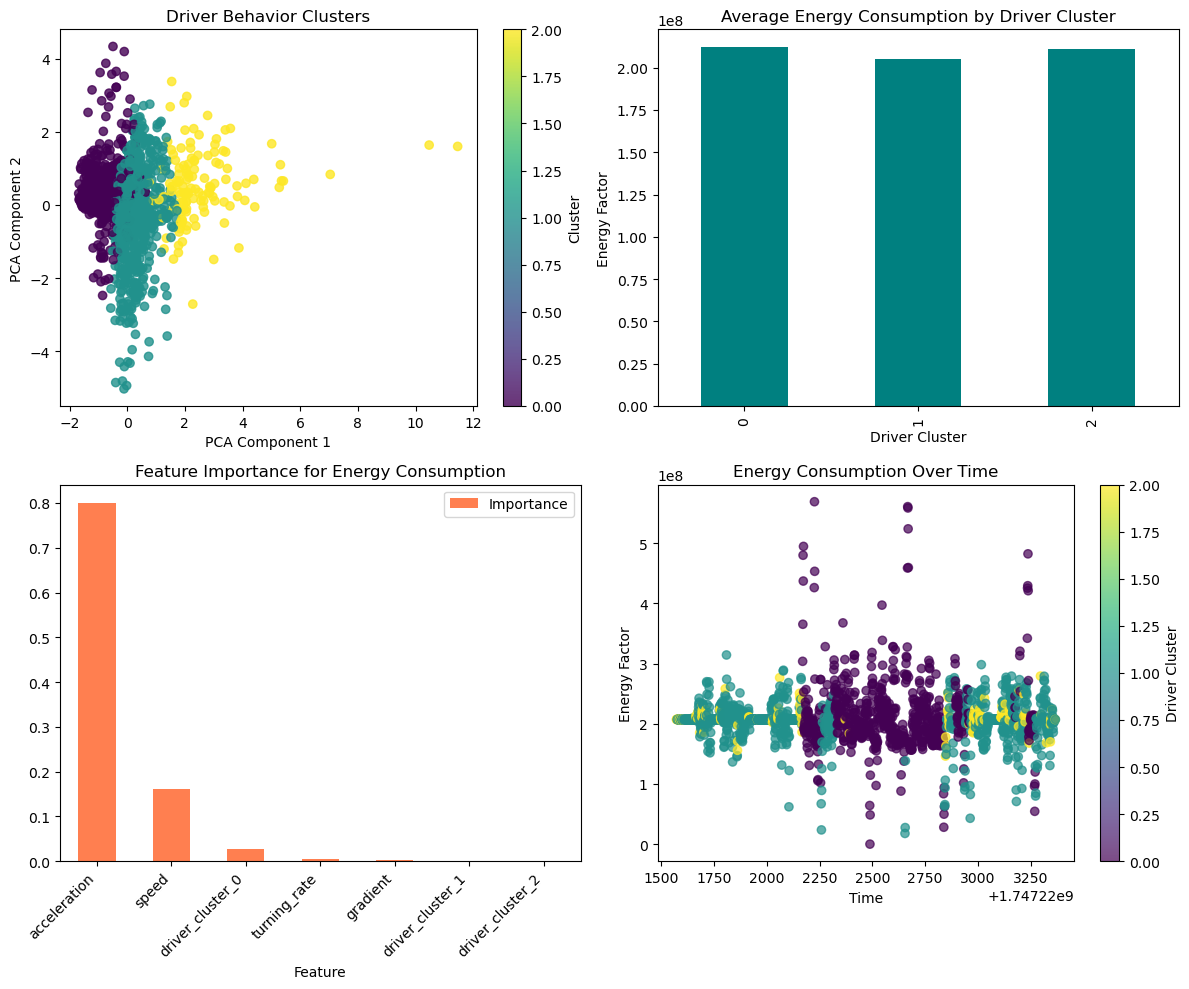

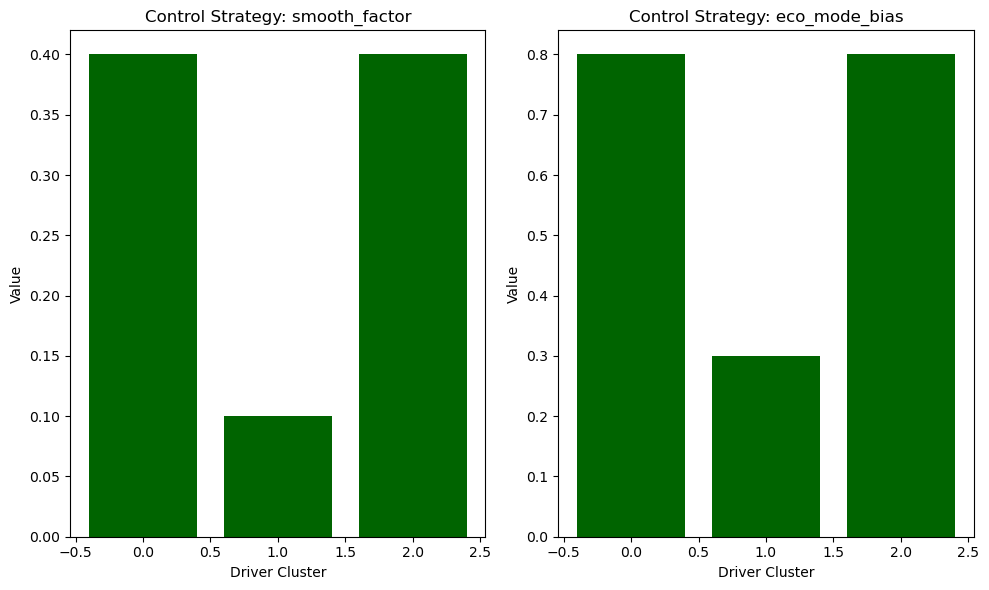

In [135]:
# Simulation method
class AdaptiveEcoDrivingController:
    def __init__(self, energy_model, control_strategies, feature_names=None):
        self.energy_model = energy_model
        self.control_strategies = control_strategies
        self.feature_names = feature_names  
        self.current_cluster = None
        self.driver_history = []
        self.strategy = None
    
    def update_driver_profile(self, recent_driving_data):
        features = ['speed', 'acceleration', 'jerk', 'turning_rate']
        X = recent_driving_data[features]
        
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        kmeans = KMeans(n_clusters=len(self.control_strategies), random_state=42)
        kmeans.fit(X_scaled)
        
        clusters = kmeans.predict(X_scaled)
        self.current_cluster = np.bincount(clusters).argmax()
        
        self.strategy = self.control_strategies[self.current_cluster]
        
        return self.current_cluster
    def recommend_actions(self, current_state):
        if self.strategy is None:
            return None
        
        state = {
            'speed': current_state.get('speed', 0),
            'gradient': current_state.get('gradient', 0),
            'turning_rate': current_state.get('turning_rate', 0),
            'acceleration': current_state.get('acceleration', 0)
        }
        
        actions = {}
        
        target_acceleration = state['acceleration']
        if self.strategy['acceleration_smoothing']:
            if target_acceleration > 0:
                target_acceleration *= (1 - self.strategy['smooth_factor'])
        
        actions['target_acceleration'] = target_acceleration
        
        if state['gradient'] > 0.03:
            actions['speed_adjustment'] = -max(0, state['speed'] * 0.1 * self.strategy['eco_mode_bias'])
        elif state['gradient'] < -0.03:
            actions['speed_adjustment'] = min(5, state['speed'] * 0.05 * (1 - self.strategy['eco_mode_bias']))
        else:
            actions['speed_adjustment'] = 0
        
        if state['turning_rate'] > 0.2:
            actions['speed_adjustment'] -= state['turning_rate'] * 5 * self.strategy['smooth_factor']
        
        base_energy = self.predict_energy_consumption(state)
        adjusted_state = state.copy()
        adjusted_state['acceleration'] = target_acceleration
        adjusted_state['speed'] += actions['speed_adjustment']
        adjusted_energy = self.predict_energy_consumption(adjusted_state)
        
        actions['expected_energy_saving'] = max(0, base_energy - adjusted_energy)
        
        return actions
    
    def predict_energy_consumption(self, state):
        """Predict energy consumption for a given state"""
        # 创建一个包含所有必要特征的DataFrame
        X = pd.DataFrame([state])
        
        # 添加聚类的one-hot编码
        for i in range(len(self.control_strategies)):
            X[f'driver_cluster_{i}'] = 1 if i == self.current_cluster else 0
        
        # 如果有保存的特征名，确保按照相同顺序排列特征
        if self.feature_names:
            # 确保所有特征都存在
            for feature in self.feature_names:
                if feature not in X.columns:
                    X[feature] = 0  # 添加缺失的特征列并填充0
            
            # 按照原始特征顺序重排列
            X = X[self.feature_names]
        
        # 预测能耗
        energy = self.energy_model.predict(X)[0]
        
        return energy

if __name__ == "__main__":
    data_file = "ts_1747221572.csv"
    
    # 解析数据
    data_dict = parse_data_fixed(data_file)
    
    # 检查原始数据
    check_missing_values(data_dict)
    
    # 运行分析
    results = run_eco_driving_analysis(data_file)
    
    if isinstance(results, str):
        print(f"Analysis error: {results}")
    
    # 检查是否有任何数据
    has_data = any(not df.empty for df in data_dict.values())
    
    if not has_data:
        print("No valid data found in the file")
    else:
        print("Successfully parsed data, proceeding with analysis...")
        
        results = run_eco_driving_analysis(data_file)
        
        if isinstance(results, str):
            print(f"Analysis error: {results}")
        else:
            print("Analysis completed successfully. Visualizing results...")
            try:
                visualize_results(results)
                
                # 创建自适应控制器
                controller = AdaptiveEcoDrivingController(
                  results['energy_model'],
                  results['control_strategies'],
                  results.get('feature_names')
                )
                
                # 示例驾驶状态
                sample_state = {
                    'speed': 60,  # km/h
                    'gradient': 0.02,  # 2% 上坡
                    'turning_rate': 0.1,  # rad/s
                    'acceleration': 1.2  # m/s²
                }
                
                # 更新驾驶者画像（使用分析结果中的最近数据）
                sample_recent_data = results['data'].tail(100)
                driver_cluster = controller.update_driver_profile(sample_recent_data)
                
                # 获取推荐的控制动作
                actions = controller.recommend_actions(sample_state)
                
                # 输出结果
                print(f"Driver Cluster: {driver_cluster}")
                print(f"Recommended Actions: {actions}")
                
                # 保存数据到CSV文件
                results['data'].to_csv('eco_driving_data.csv', index=False)
                
                # 保存聚类结果
                with open('cluster_profiles.txt', 'w') as f:
                    for cluster, profile in results['cluster_profiles'].items():
                        f.write(f"Cluster {cluster}:\n")
                        for key, value in profile.items():
                            f.write(f"  {key}: {value:.4f}\n")
                        f.write("\n")
                
                # 保存控制策略
                with open('control_strategies.txt', 'w') as f:
                    for cluster, strategy in results['control_strategies'].items():
                        f.write(f"Cluster {cluster}:\n")
                        for key, value in strategy.items():
                            f.write(f"  {key}: {value}\n")
                        f.write("\n")
                        
                # 输出特征重要性
                print("\nFeature Importance for Energy Consumption:")
                for feature, importance in sorted(
                    results['feature_importance'].items(), 
                    key=lambda x: x[1], 
                    reverse=True
                ):
                    print(f"  {feature}: {importance:.4f}")
                
                # 输出能源节约总结
                print("\nEco-Driving Analysis Summary:")
                energy_data = results['data']['energy_factor']
                print(f"  Average Energy Factor: {energy_data.mean():.2f}")
                print(f"  Energy Factor Range: {energy_data.min():.2f} - {energy_data.max():.2f}")
                
                # 输出每个驾驶者类别的特点
                print("\nDriver Behavior Clusters:")
                for cluster, profile in results['cluster_profiles'].items():
                    print(f"  Cluster {cluster}:")
                    print(f"    Average Speed: {profile['avg_speed']:.2f} km/h")
                    print(f"    Average Acceleration: {profile['avg_acceleration']:.2f} m/s²")
                    print(f"    Energy Efficiency: {profile['energy_efficiency']:.2f}")
                
                print("\nEco-driving analysis and visualization completed successfully!")
                print("Results saved to:")
                print("  - eco_driving_data.csv")
                print("  - cluster_profiles.txt")
                print("  - control_strategies.txt")
                print("  - eco_driving_results.png")
                print("  - control_strategies.png")
                
            except Exception as e:
                print(f"Error during visualization or processing: {e}")
                import traceback
                traceback.print_exc()
